# 6: Predictive Modeling

In [68]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV, KFold
import re
import warnings 
warnings.filterwarnings("ignore")
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression

### Feature Engineering

In [69]:
# load the dataset
df = pd.read_csv('test_labeled_1.csv')

# convert date ti datetime
df['date'] = pd.to_datetime(df['date'])

# Sentiment score mapping
sentiment_map = {'Positive': 1, 'Negative': -1, 'Neutral': 0}
df['sentiment_score'] = df['sentiment'].map(sentiment_map)

# Basic features
df['body_length'] = df['body'].astype(str).apply(len)
df['word_count'] = df['body'].astype(str).apply(lambda x: len(x.split()))
df['avg_word_length'] = df['body_length'] / df['word_count'].replace(0, np.nan)
df['exclaim_count'] = df['body'].astype(str).apply(lambda x: x.count('!'))

# Positive/Negative term counts
positive_terms = ['great', 'thank', 'happy', 'excellent', 'appreciate']
negative_terms = ['issue', 'delay', 'frustrated', 'problem', 'complain']

df['pos_term_count'] = df['body'].astype(str).apply(lambda x: sum(word in x.lower() for word in positive_terms))
df['neg_term_count'] = df['body'].astype(str).apply(lambda x: sum(word in x.lower() for word in negative_terms))

# Monthly message count and sentiment ratio
df['month_period'] = df['date'].dt.to_period('M')
df['msg_count_month'] = df.groupby(['from', 'month_period'])['body'].transform('count')

monthly_sentiment = df.groupby(['from', 'month_period'])['sentiment'].value_counts().unstack(fill_value=0)
monthly_sentiment['sentiment_ratio'] = monthly_sentiment.get('Positive', 0) / (monthly_sentiment.get('Negative', 1))
df = df.merge(monthly_sentiment['sentiment_ratio'], on=['from', 'month_period'], how='left')


features = [
    'body_length', 'word_count', 'avg_word_length', 'exclaim_count',
    'pos_term_count', 'neg_term_count', 'msg_count_month', 'sentiment_ratio'
]



In [70]:


# Feature matrix
X = df[features].fillna(0)
y = df['sentiment_score']

# Handle inf / NaN in sentiment_ratio
X['sentiment_ratio'] = X['sentiment_ratio'].replace([np.inf, -np.inf], np.nan).fillna(1.0)
assert np.isfinite(X.values).all()

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline with standardization + linear regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

# Train model
pipeline.fit(X_train, y_train)

# Evaluation
y_pred = pipeline.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")


RMSE: 0.638
R²: 0.143


In [71]:
# Feature matrix

X = df[features].fillna(0)
y = df['sentiment_score']

X['sentiment_ratio'] = X['sentiment_ratio'].replace([np.inf, -np.inf], np.nan).fillna(1.0)
assert np.isfinite(X.values).all()

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluation
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"New RMSE: {rmse:.3f}")
print(f"New R²: {r2:.3f}")

New RMSE: 0.638
New R²: 0.143


### Model Development

In [72]:
# Split data into feature variables X and target variables Y
X = df[features].fillna(0)
y = df['sentiment_score']

X['sentiment_ratio'] = X['sentiment_ratio'].replace([np.inf, -np.inf], np.nan).fillna(1.0)
assert np.isfinite(X.values).all(), "Feature matrix still contains non-finite values!"

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', ElasticNet())
])

param_grid = {
    'regressor__alpha': [0.01, 0.1, 1.0, 10.0],
    'regressor__l1_ratio': [0.2, 0.5, 0.8]  # 0 = Ridge-like, 1 = Lasso-like
}
cv = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring='r2')
grid_search.fit(X, y)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X)

rmse = mean_squared_error(y, y_pred, squared=False)
r2 = r2_score(y, y_pred)

print(f'Best Alpha: {grid_search.best_params_["regressor__alpha"]}')
print(f'RMSE: {rmse:.3f}')
print(f'R² Score: {r2:.3f}')

Best Alpha: 0.01
RMSE: 0.622
R² Score: 0.173


In [73]:
coefficients = pd.DataFrame({
    'Feature': features,
    'Coefficient': best_model.named_steps['regressor'].coef_
}).sort_values(by='Coefficient', ascending=False)
print(coefficients)

           Feature  Coefficient
4   pos_term_count     0.198043
1       word_count     0.102084
2  avg_word_length     0.078698
7  sentiment_ratio     0.037660
0      body_length     0.014427
3    exclaim_count     0.000000
5   neg_term_count    -0.000315
6  msg_count_month    -0.024943


In [65]:
# Rebuild everything consistently and keep feature columns stable
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV
from sklearn.impute import SimpleImputer
import re

# 1) Re-load and re-create features exactly as in modeling step
def safe_len(s):
    return len(s) if isinstance(s, str) else 0

def safe_word_count(s):
    return len(s.split()) if isinstance(s, str) else 0

def count_regex(pattern, s):
    if not isinstance(s, str):
        return 0
    return len(re.findall(pattern, s, flags=re.IGNORECASE))


df['date'] = pd.to_datetime(df['date'], errors='coerce')
sentiment_map = {'Positive': 1, 'Negative': -1, 'Neutral': 0}
df['sentiment_score'] = df['sentiment'].map(sentiment_map)

df['char_len'] = df['body'].apply(safe_len)
df['word_count'] = df['body'].apply(safe_word_count)
df['avg_word_len'] = (df['char_len'] / df['word_count'].replace(0, np.nan)).fillna(0.0)

positive_patterns = r'\b(thank|thanks|appreciate|great|good|well done|congrats|pleased|glad|happy|awesome|excellent)\b'
negative_patterns = r'\b(unfortunately|issue|problem|delay|angry|frustrated|disappointed|concern|complain|urgent|escalate)\b'
df['pos_term_count'] = df['body'].apply(lambda x: count_regex(positive_patterns, x))
df['neg_term_count'] = df['body'].apply(lambda x: count_regex(negative_patterns, x))
df['pos_neg_ratio'] = (df['pos_term_count'] / df['neg_term_count'].replace(0, np.nan)).replace([np.inf, -np.inf], np.nan).fillna(0.0)

df['exclaim_count'] = df['body'].apply(lambda x: x.count('!') if isinstance(x, str) else 0)
df['question_count'] = df['body'].apply(lambda x: x.count('?') if isinstance(x, str) else 0)
df['caps_ratio'] = df['body'].apply(lambda x: (sum(c.isupper() for c in x) / max(1, len(x))) if isinstance(x, str) else 0.0)

df['year_month'] = df['date'].dt.to_period('M')

agg_funcs = {
    'sentiment_score': ['mean', 'sum', 'count'],
    'char_len': ['mean', 'median', 'std', 'max'],
    'word_count': ['mean', 'median', 'std', 'max'],
    'avg_word_len': ['mean', 'median'],
    'pos_term_count': ['mean', 'sum'],
    'neg_term_count': ['mean', 'sum'],
    'pos_neg_ratio': ['mean'],
    'exclaim_count': ['mean', 'sum'],
    'question_count': ['mean', 'sum'],
    'caps_ratio': ['mean']
}
monthly = df.groupby(['from', 'year_month']).agg(agg_funcs)
monthly.columns = ['_'.join(col).strip() for col in monthly.columns.values]
monthly = monthly.reset_index()
monthly.rename(columns={
    'sentiment_score_mean': 'target_monthly_avg',
    'sentiment_score_sum': 'target_monthly_sum',
    'sentiment_score_count': 'msg_count_month'
}, inplace=True)

monthly['neg_share'] = (monthly['neg_term_count_sum'] / monthly['msg_count_month'].replace(0, np.nan)).fillna(0.0)
monthly['pos_share'] = (monthly['pos_term_count_sum'] / monthly['msg_count_month'].replace(0, np.nan)).fillna(0.0)
monthly['exclaim_per_msg'] = (monthly['exclaim_count_sum'] / monthly['msg_count_month'].replace(0, np.nan)).fillna(0.0)
monthly['question_per_msg'] = (monthly['question_count_sum'] / monthly['msg_count_month'].replace(0, np.nan)).fillna(0.0)

monthly_sorted = monthly.sort_values(['from', 'year_month'])

def add_employee_rolling_features(mdf, cols, window=3):
    for c in cols:
        mdf[f'{c}_roll{window}'] = (
            mdf.groupby('from')[c]
               .transform(lambda s: s.shift(1).rolling(window=window, min_periods=1).mean())
        )
    return mdf

trend_cols = ['target_monthly_avg', 'pos_share', 'neg_share', 'caps_ratio_mean', 'msg_count_month']
monthly_sorted = add_employee_rolling_features(monthly_sorted, trend_cols, window=3)

target = 'target_monthly_avg'
feature_cols = [
    'msg_count_month',
    'char_len_mean','char_len_median','char_len_std','char_len_max',
    'word_count_mean','word_count_median','word_count_std','word_count_max',
    'avg_word_len_mean','avg_word_len_median',
    'pos_term_count_mean','pos_term_count_sum',
    'neg_term_count_mean','neg_term_count_sum',
    'pos_neg_ratio_mean',
    'exclaim_count_mean','exclaim_count_sum',
    'question_count_mean','question_count_sum',
    'caps_ratio_mean',
    'neg_share','pos_share','exclaim_per_msg','question_per_msg',
    'target_monthly_avg_roll3','pos_share_roll3','neg_share_roll3','caps_ratio_mean_roll3','msg_count_month_roll3'
]

existing_features = [c for c in feature_cols if c in monthly_sorted.columns]
X = monthly_sorted[existing_features].copy()
y = monthly_sorted[target].copy()

# 2) Train/test split (keep references)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=max(0.2, min(0.4, 1 - 1.0 * (len(X) - 1) / max(1, len(X)))), random_state=42
)

# 3) Build pipeline & pick best model by CV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV

preprocess = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), existing_features)
    ],
    remainder='drop'
)

models = {
    'RidgeCV': RidgeCV(alphas=np.logspace(-3, 3, 25), cv=5),
    'LassoCV': LassoCV(alphas=np.logspace(-3, 1, 25), cv=5, max_iter=10000, random_state=42),
    'ElasticNetCV': ElasticNetCV(l1_ratio=[0.2,0.4,0.6,0.8,0.9], alphas=np.logspace(-3, 1, 25),
                                 cv=5, max_iter=10000, random_state=42)
}

best_name, best_cv, best_model = None, -np.inf, None
cv = KFold(n_splits=min(5, max(2, len(X)//2)), shuffle=True, random_state=42)
for name, base in models.items():
    pipe = Pipeline(steps=[('prep', preprocess), ('model', base)])
    scores = cross_val_score(pipe, X, y, cv=cv, scoring='r2')
    if scores.mean() > best_cv:
        best_cv, best_name, best_model = scores.mean(), name, pipe

best_model.fit(X_train, y_train)

# 4) Helper to align columns before predict (safety net)
def align_columns_for_predict(model_pipeline, X_like):
    # Ensure X_like has all columns the ColumnTransformer expects (existing_features), in order.
    needed = existing_features
    X_fixed = X_like.copy()
    # Add any missing columns with zeros
    for col in needed:
        if col not in X_fixed.columns:
            X_fixed[col] = 0.0
    # Remove extra columns if any (shouldn’t be necessary but safe)
    X_fixed = X_fixed[needed]
    return X_fixed

# 5) Build y_pred with aligned columns to avoid the error
X_test_aligned = align_columns_for_predict(best_model, X_test)
y_pred = best_model.predict(X_test_aligned)

mse = mean_squared_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)
print(f'Best model by CV: {best_name} (CV R2 = {best_cv:.4f})')
print('Hold-out Evaluation:')
print(f'- MSE: {mse:.4f}')
print(f'- R2 : {r2:.4f}')

Best model by CV: RidgeCV (CV R2 = 0.0786)
Hold-out Evaluation:
- MSE: 0.0506
- R2 : 0.0744


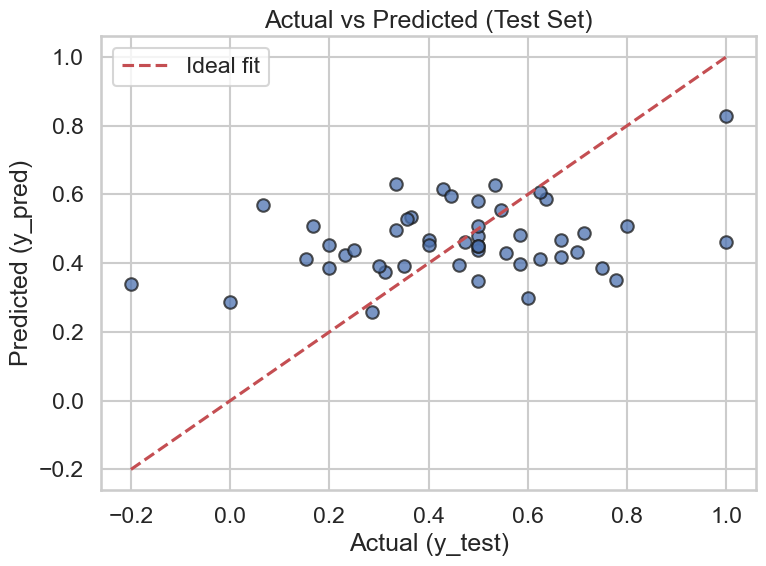

In [66]:
sns.set(style="whitegrid", context="talk")

# Predictions and residuals
y_pred = best_model.predict(X_test_aligned)
residuals = y_test - y_pred

# 1) Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.75, edgecolor='k')
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, 'r--', label='Ideal fit')
plt.xlabel('Actual (y_test)')
plt.ylabel('Predicted (y_pred)')
plt.title('Actual vs Predicted (Test Set)')
plt.legend()
plt.tight_layout()
plt.show()

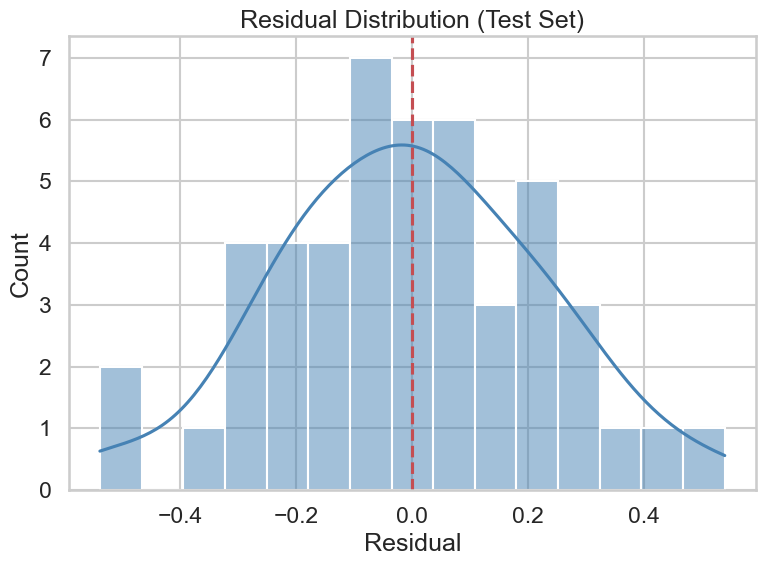

In [67]:
#Residual distribution
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=15, color='steelblue')
plt.axvline(0, color='r', linestyle='--')
plt.xlabel('Residual')
plt.title('Residual Distribution (Test Set)')
plt.tight_layout()
plt.show()